# Answering Business Questions and Analyzing the Market using SQL

The Chinook record store has just signed a deal with a new record label, and we need to select the first 3 albums that will be added to the store, from a list of 4. All 4 albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce.

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We need find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

## Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'


def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = """SELECT name,type FROM sqlite_master WHERE type IN ("table","view");"""
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Importing the Chinook Database Schema

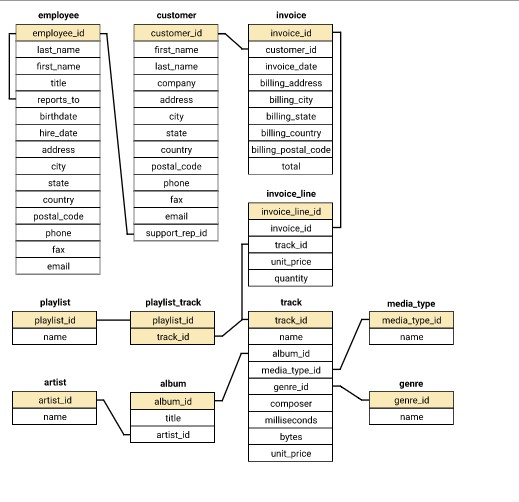

In [1]:
from IPython.display import Image
Image("https://sun9-63.userapi.com/c206716/v206716987/4543c/6zGlhv-CbfE.jpg")

## Selecting Albums to Purchase

In [2]:
albums_to_purchase = '''

WITH usa_tracks_sold AS
   (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA")

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / 
    (SELECT COUNT(*) from usa_tracks_sold) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


## Analyzing Employee Sales Performance

In [3]:
employee_sales_performance = '''SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(i.total) as total_sales
FROM employee e
INNER JOIN customer c on c.support_rep_id = e.employee_id  
INNER JOIN invoice i on i.customer_id = c.customer_id
GROUP BY 1 LIMIT 10'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


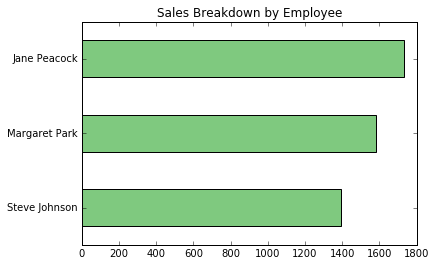

In [4]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)

employee_sales.plot.barh(legend=False, 
                         title='Sales Breakdown by Employee',
                         colormap=plt.cm.Accent)
plt.ylabel("")
plt.show()

We can notice 2 things. 
- 1st. There is a difference of about 20% between Steve and Jane.
- 2nd. Jane has been hired 6 months before Steve.

And we can assume that the 1st is the result of the 2nd.

## Analyzing Sales by Country

There are several countries that has only 1 customer, we want those to form one group "other" and be at the bottom of our table, which we are going to do through the code below. 

In [5]:
sales_by_country = '''
WITH country_or_other AS
    (SELECT
       CASE
           WHEN (SELECT count(*)
                 FROM customer
                 where country = c.country) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id)

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [6]:
test = '''SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1'''
        
run_query(test)



,invoice_id,first_track_id
0,1,1158
1,2,201
2,3,2516
3,4,748
4,5,1986
5,6,30
6,7,42
7,8,81
8,9,196
9,10,2663


And now by using WHEN "LIST A" EXCEPT "LIST B" is NULL both ways, coupled with CASE statement we will find those purchases that were album purchases.

In [7]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1)

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                  ) IS NULL
             AND
                 (SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id) 
                                      ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


We can see that the 18% of the purchases are albums, which means it's too risky to shift to only track purchasing because the share of album purchases of almost one fivth of the total is significant.